### Ordered Dropout Example on MNIST Dataset

In [1]:
%matplotlib inline

import sys

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from numpy.random import randint

import matplotlib.pyplot as plt

sys.path.append('./od')

### OD layers

In [2]:
from layers.cnn import ODConv2d
from layers.linear import ODLinear

In [3]:
m=5
n_epochs = 10
batch_size_train = 64
batch_size_test = 1024
learning_rate = 0.01
momentum = 0.9
log_interval = 300

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ODConv2d(1, 10, kernel_size=5)
        self.conv2 = ODConv2d(10, 20, kernel_size=5)
        self.fc1 = ODLinear(320, 50)
        self.fc2 = ODLinear(50, 10)

    def forward(self, x, p=None):
        b = x.shape[0]
        x = F.relu(F.max_pool2d(self.conv1(x, p=p), 2))
        x = F.relu(F.max_pool2d(self.conv2(x, p=p), 2))
        x = x.view(b, -1)
        x = F.relu(self.fc1(x, p=p))
        x = self.fc2(x, p=1.) 
        # last layer is always with p=1. since the output size has to be preserved
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()

### Uniform ordered dropout
- same for each layer, i.e., sampled only once

In [7]:
def sample():
    return (randint(m) + 1) / m

### Train and test

In [8]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        p = sample()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data, p=p)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    network.eval()
    p_s = np.arange(1, m + 1)/m
    p_s_acc = []
    for p in p_s: 
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = network(data, p=p)
                test_loss += criterion(output, target).item() * data.shape[0]
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        acc = 100. * correct / len(test_loader.dataset)
        print(f"\np = {p}:")
        print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), acc))
        p_s_acc.append(acc)
    return p_s, p_s_acc

### Training

In [9]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


p = 0.2:
Test set: Avg. loss: 2.3013, Accuracy: 1234/10000 (12%)


p = 0.4:
Test set: Avg. loss: 2.3044, Accuracy: 355/10000 (4%)


p = 0.6:
Test set: Avg. loss: 2.3059, Accuracy: 622/10000 (6%)


p = 0.8:
Test set: Avg. loss: 2.3087, Accuracy: 949/10000 (9%)


p = 1.0:
Test set: Avg. loss: 2.3231, Accuracy: 1142/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302532
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.250701
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.336875
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.100744

p = 0.2:
Test set: Avg. loss: 0.3446, Accuracy: 8836/10000 (88%)


p = 0.4:
Test set: Avg. loss: 0.1334, Accuracy: 9569/10000 (96%)


p = 0.6:
Test set: Avg. loss: 0.0955, Accuracy: 9696/10000 (97%)


p = 0.8:
Test set: Avg. loss: 0.0918, Accuracy: 9710/10000 (97%)


p = 1.0:
Test set: Avg. loss: 0.0884, Accuracy: 9723/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.269227
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.065388
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.104

### Evaluate

- performance along different widths


p = 0.2:
Test set: Avg. loss: 0.1236, Accuracy: 9626/10000 (96%)


p = 0.4:
Test set: Avg. loss: 0.0630, Accuracy: 9809/10000 (98%)


p = 0.6:
Test set: Avg. loss: 0.0463, Accuracy: 9872/10000 (99%)


p = 0.8:
Test set: Avg. loss: 0.0459, Accuracy: 9864/10000 (99%)


p = 1.0:
Test set: Avg. loss: 0.0461, Accuracy: 9865/10000 (99%)



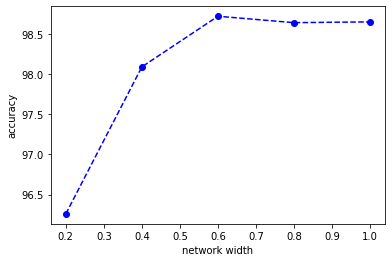

In [11]:
fig = plt.figure()
p_s, p_s_acc = test()
plt.plot(p_s, p_s_acc, 'bo--')
plt.xlabel('network width')
plt.ylabel('accuracy')
plt.show()